In [63]:
# Imports
import numpy as np
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import hann, butter, filtfilt, lfilter
from scipy import signal
import matplotlib.pyplot as plt
import settings

In [64]:
# Constants
fc = 24e9
c = 3e8
ld = c/fc

print("Transmit frequency: " + str(fc))
print("Speed of light: " + str(c))
print("Lambda: " + str(ld))

# Parameter
N_FFT = 512        # Number of measuring points 
FS = 14000          # Sampling frequency
wFS = FS*2*np.pi    # circular sampling frequency
DT = 1/FS           # Time per sample
TS = DT*N_FFT       # Sampling time

print(DT,TS)

Transmit frequency: 24000000000.0
Speed of light: 300000000.0
Lambda: 0.0125
7.142857142857143e-05 0.036571428571428574


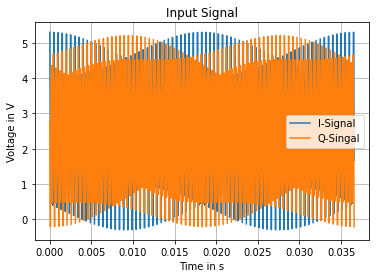

In [65]:

# demo signal
t = np.linspace(0,TS,N_FFT) # time vector

# main Signal
f1 = 4000                   # Frequency for the demo signal
w1 = 2*np.pi*f1             # circular frequency
A1 = 2.500                  # Amplitude
DC = 2.5                    # DC value
I1 = A1*np.cos(w1*t) + DC   # Build the signal

Q1 = A1*-np.sin(w1*t) + DC

# noise 1
# 20kHz
fn1 = 20000                 # Frequency of the noise
wn1 = 2*np.pi*fn1           # circular frequency
An1 = 0.100                 # Amplitude
In1 = An1*np.cos(wn1*t)     # Build the signal

# noise 2
# 50Hz
fn2 = 50
wn2 = 2*np.pi*fn1
An2 = 0.100
In2 = An2*np.cos(wn2*t)

# noise 3
# 50Hz
fn3 = 1.1e6
wn3 = 2*np.pi*fn1
An3 = 0.5
In3 = An2*np.cos(wn2*t)

# Signal
I = I1 + In1 + In2 + In3 # Signal I
Q = Q1 + In1 + In2 + In3 # Signal Q
# y= I + Q1*1j

# Plot of the Signal
plt.plot(t,I,t,Q)
plt.grid()
plt.title("Input Signal")
plt.xlabel("Time in s")
plt.ylabel("Voltage in V")
plt.legend(["I-Signal", "Q-Singal"])
plt.savefig("Input.jpg",dpi=100)
plt.show()

2.5


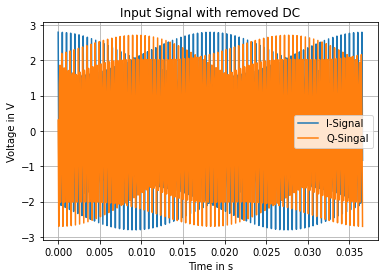

In [66]:
# Calculate DC
DC_I = 1/N_FFT * np.sum(I)
DC_Q = 1/N_FFT * np.sum(Q)
print(DC)

# remove DC
I = I-DC_I
Q = Q-DC_Q

plt.plot(t,I,t,Q)
plt.grid()
plt.title("Input Signal with removed DC")
plt.xlabel("Time in s")
plt.ylabel("Voltage in V")
plt.legend(["I-Signal", "Q-Singal"])
plt.savefig("DC_free_input.jpg",dpi=100)
plt.show()

## Butterworth

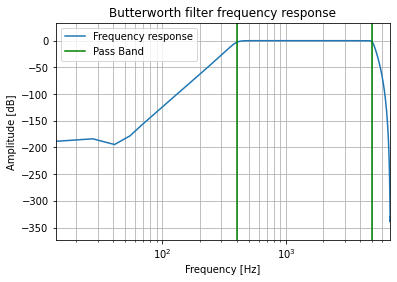

In [67]:
# create the filter
b,a = butter(10, np.multiply([400, 5000], 2*np.pi), btype="band", fs=(FS*2*np.pi), output='ba', analog=False)

# frequency response
w,h = signal.freqz(b,a, worN=N_FFT,fs=wFS)
plt.semilogx(w/(2*np.pi),20*np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.margins(0, 0.1)
plt.axvline(400, color='green') # highpass frequency
plt.axvline(5000, color='green') # lowpass frequency
plt.legend(["Frequency response","Pass Band"])
plt.savefig("Filter.jpg", dpi=150)
plt.show()

## FIR-Filter

In [68]:
#fir =  signal.firls(settings.N_samp, np.array([400 4500]), fs=settings.FS)

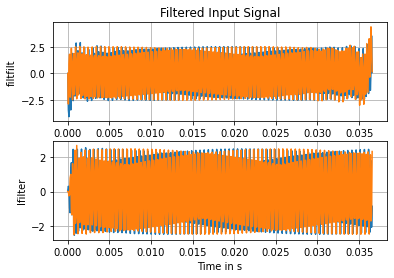

In [69]:
# filter the signal with lfilter
I_filt1 = lfilter(b,a,I)
Q_filt1 = lfilter(b,a,Q)

# filter the signal with filtfilt
I_filt2 = filtfilt(b,a,I)
Q_filt2 = filtfilt(b,a,Q)

# plot the filtered signals
plt.subplot(211)
plt.plot(t,I_filt2,t,Q_filt2)
plt.title("Filtered Input Signal")
plt.ylabel("filtfilt")
plt.grid()

plt.subplot(212)
plt.plot(t,I_filt1,t,Q_filt1)
plt.xlabel("Time in s")
plt.ylabel("lfilter")
plt.grid()
plt.savefig("Filter_compared.jpg", dpi=100)
plt.show()


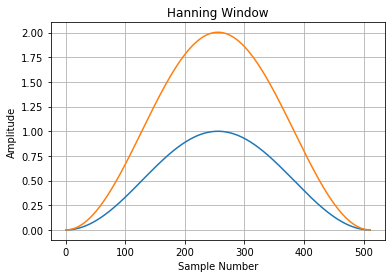

1.0


In [70]:
#create a Window
window = hann(N_FFT, sym=True)
window_av = np.average(window)
window_norm = window/window_av
plt.plot(window)
plt.plot(window_norm)
plt.title("Hanning Window")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.grid()
plt.savefig("Window.jpg",dpi=150)
plt.show()

print(np.average(window_norm))



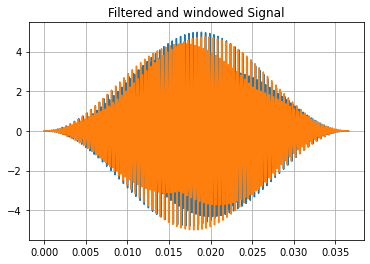

In [71]:
# apply the Window
I_filt = np.multiply(window_norm,I_filt1)
Q_filt = np.multiply(window_norm,Q_filt1) 
plt.plot(t,I_filt,t,Q_filt)
plt.grid()
plt.title("Filtered and windowed Signal")
plt.savefig("filtered_windowed.jpg", dpi=100)
plt.show()

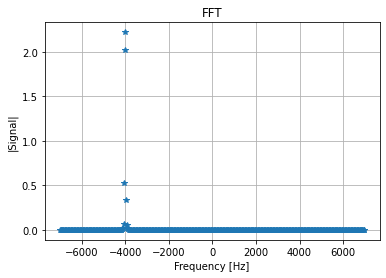

In [72]:
# Combining I and Q signal
z_t = I_filt + Q_filt * 1j

# Perform the FFT
z_f = fftshift(fft(z_t,norm='forward'))
x_f = fftshift(fftfreq(N_FFT,DT))
z_f_abs = np.abs(z_f)

# Plot the FFT
plt.plot((x_f),z_f_abs,'*')
plt.grid()
plt.title("FFT")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|Signal|")
plt.savefig("FFT.jpg",dpi=100)
plt.show()

In [73]:
# Calculate resulting speed -> v = fd/2 * lamda
# z = np.zeros((N_FFT,2))

# z[:,0] = z_f_abs
# z[:,1] = x_f

n_max = np.argmax(z_f_abs)
print("n Max: " + str(n_max))
max_f = x_f[n_max-1]
print("n Max: " + str(n_max) + "; max f:" + str(max_f))
print("end of file")

v = 3.6*max_f/2*ld
print("Simulated Speed: "+ str(v))

n Max: 109
n Max: 109; max f:-4046.8749999999995
end of file
Simulated Speed: -91.0546875
